<a href="https://colab.research.google.com/github/AmalPeediyakkalShaji10/AIProjectActiGence/blob/main/AI%20LSTM%20AMZN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [7]:
# 1. Data Collection
# -----------------------------
ticker = 'AMZN'
start_date = '2018-01-01'  # 5 years ago
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

data = yf.download(ticker, start=start_date, end=end_date)
data.dropna(inplace=True)

# Reset index so "Date" becomes a column
data.reset_index(inplace=True)

# For convenience, rename columns to standard naming
data.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)

data.sort_values('date', inplace=True)
data.reset_index(drop=True, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [8]:
# 2. Compute SMA, Support, Resistance, RSI
# -----------------------------
def compute_rsi(series, window=14):
    """Compute the RSI for a stock price series."""
    delta = series.diff()
    gain = (delta.mask(delta < 0, 0)).rolling(window=window).mean()
    loss = (-delta.mask(delta > 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['rsi'] = compute_rsi(data['close'], 14)

# SMA (Simple Moving Average)
data['sma_20'] = data['close'].rolling(window=20).mean()

# Support (rolling min)
data['support'] = data['close'].rolling(window=20).min()

# Resistance (rolling max)
data['resistance'] = data['close'].rolling(window=20).max()

# Drop initial NaNs from rolling calculations
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [9]:
# 3. Prepare Data for Training
# -----------------------------
lookback = 30  # Number of past days we use as features

feature_cols = ['open', 'high', 'low', 'close', 'volume', 'rsi', 'sma_20', 'support', 'resistance']

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[feature_cols])

# Build sequences (X) and labels (y)
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, :])  # 30 rows of features
    y.append(scaled_data[i, feature_cols.index('close')])  # next day's close (scaled)

X = np.array(X)
y = np.array(y)

# Unscaled close values for evaluation
actual_close = data['close'].values[lookback:]

In [10]:
# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
actual_close_test = actual_close[train_size:]

In [11]:
# 4. Build and Train LSTM Model
# -----------------------------
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))  # single output: next day's close

model.compile(optimizer='adam', loss='mean_squared_error')

epochs = 30
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0246 - val_loss: 0.0064
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 10/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 11/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 12/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0018 - val_l

In [12]:
# 5. Prediction
# -----------------------------
y_pred_scaled = model.predict(X_test)

# Invert scaling
pred_features_placeholder = np.zeros((len(y_pred_scaled), len(feature_cols)))
pred_features_placeholder[:, feature_cols.index('close')] = y_pred_scaled[:, 0]
pred_inverted = scaler.inverse_transform(pred_features_placeholder)
pred_close = pred_inverted[:, feature_cols.index('close')]

# Evaluate
mse = mean_squared_error(actual_close_test, pred_close)
rmse = sqrt(mse)
r2 = r2_score(actual_close_test, pred_close)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2 : {r2:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
Test MSE: 32.2976
Test RMSE: 5.6831
Test R2 : 0.9546


In [13]:
# 6. Generate Buy/Hold/Sell Signals
# -----------------------------
threshold = 0.02  # 2% threshold for signal generation
signals = []
for actual, predicted in zip(actual_close_test, pred_close):
    if predicted > actual * (1 + threshold):  # Predicted price is significantly higher than actual
        signals.append('BUY')
    elif predicted < actual * (1 - threshold):  # Predicted price is significantly lower than actual
        signals.append('SELL')
    else:
        signals.append('HOLD')

In [14]:
# Flatten necessary arrays (if not already flattened)
test_dates_1d = np.array(data['date'][lookback + train_size:]).ravel()  # Test dates
actual_close_test_1d = np.array(actual_close_test).ravel()  # Actual close prices
pred_close_1d = np.array(pred_close).ravel()  # Predicted close prices
signals_1d = np.array(signals).ravel()  # Generated signals (e.g., BUY/SELL/HOLD)

# Double-check that all lengths match
print("Length of test_dates:", len(test_dates_1d))
print("Length of actual_close_test:", len(actual_close_test_1d))
print("Length of pred_close:", len(pred_close_1d))
print("Length of signals:", len(signals_1d))

# Create a DataFrame to store results
signal_df = pd.DataFrame({
    'date': test_dates_1d,
    'actual_price': actual_close_test_1d,
    'predicted_price': pred_close_1d,
    'signal': signals_1d
})

# Display the first 50 rows of the signal DataFrame
print(signal_df.head(50))


Length of test_dates: 346
Length of actual_close_test: 346
Length of pred_close: 346
Length of signals: 346
         date  actual_price  predicted_price signal
0  2023-09-08    138.229996       138.987972   HOLD
1  2023-09-11    143.100006       139.979714   SELL
2  2023-09-12    141.229996       141.481117   HOLD
3  2023-09-13    144.850006       142.271275   HOLD
4  2023-09-14    144.720001       143.128925   HOLD
5  2023-09-15    140.389999       144.879315    BUY
6  2023-09-18    139.979996       144.065609    BUY
7  2023-09-19    137.630005       143.282153    BUY
8  2023-09-20    135.289993       141.461725    BUY
9  2023-09-21    129.330002       139.708017    BUY
10 2023-09-22    129.119995       136.173870    BUY
11 2023-09-25    131.270004       133.451436   HOLD
12 2023-09-26    125.980003       132.362729    BUY
13 2023-09-27    125.980003       130.993651    BUY
14 2023-09-28    125.980003       129.321622    BUY
15 2023-09-29    127.120003       127.960415   HOLD
16 2023-

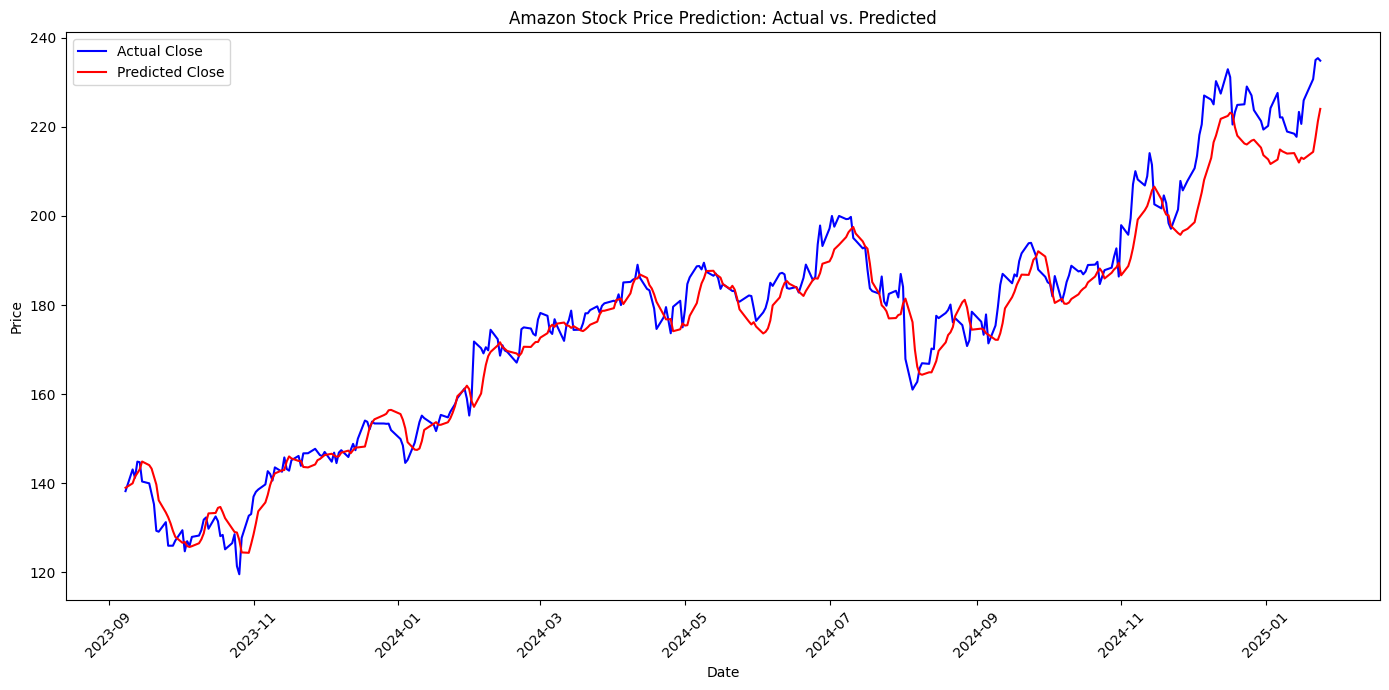

In [15]:
plt.figure(figsize=(14, 7))

# Plot Actual Prices
plt.plot(data['date'][lookback+train_size:], actual_close_test, label='Actual Close', color='blue')

# Plot Predicted Prices
plt.plot(data['date'][lookback+train_size:], pred_close, label='Predicted Close', color='red')

# Add Titles and Labels
plt.title('Amazon Stock Price Prediction: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Format x-axis
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


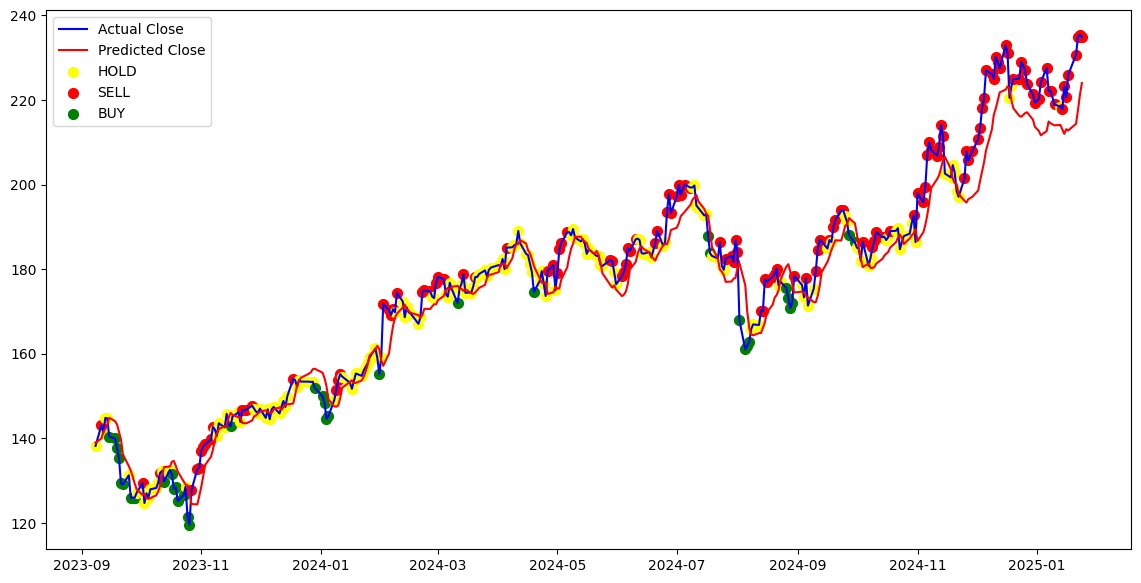

In [16]:
# 7. Visualization with Signals
# -----------------------------
plt.figure(figsize=(14, 7))

# Plot Actual and Predicted Prices
plt.plot(data['date'][lookback+train_size:], actual_close_test, label='Actual Close', color='blue')
plt.plot(data['date'][lookback+train_size:], pred_close, label='Predicted Close', color='red')

# Overlay Buy/Hold/Sell Signals
signal_colors = {'BUY': 'green', 'SELL': 'red', 'HOLD': 'yellow'}
for i, signal in enumerate(signals):
    if signal in signal_colors:
        plt.scatter(data['date'][lookback+train_size:].iloc[i], actual_close_test[i], color=signal_colors[signal], label=signal, s=50)

# Deduplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())